In [47]:
import json
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

# import statsmodels.api as sm
# from scipy import stats
# from patsy import dmatrices
from scipy.stats import kde
# from scipy.stats import shapiro
# from scipy.stats import probplot
# from scipy.stats import ranksums
# from statsmodels.stats.outliers_influence import variance_inflation_factor
from pandas_profiling import ProfileReport
# from statsmodels.formula.api import ols

In [33]:
with open('/content/drive/Shared drives/H1L4/data_final.json') as file_json:
    data_json = json.load(file_json)
    
df = pd.DataFrame()
df['subject'] = list(''.join(re.compile('[A-Z]').findall(x['subject'])) for x in data_json['data'])
df['frame_name'] = list(x['video_name'].split('.')[0]+'_frame'+str(x['frame_num']) for x in data_json['data'])
df['label'] = list(x['label'] for x in data_json['data'])
df['head_pose_pitch'] = list(float(list(x['head_pose'].values())[0]) for x in data_json['data'])
df['head_pose_yaw'] = list(float(list(x['head_pose'].values())[1]) for x in data_json['data'])
df['head_pose_roll'] = list(float(list(x['head_pose'].values())[2]) for x in data_json['data'])

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13563 entries, 0 to 13562
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   subject          13563 non-null  object 
 1   frame_name       13563 non-null  object 
 2   label            13563 non-null  object 
 3   head_pose_pitch  13563 non-null  float64
 4   head_pose_yaw    13563 non-null  float64
 5   head_pose_roll   13563 non-null  float64
dtypes: float64(3), object(3)
memory usage: 635.9+ KB


In [35]:
df

,subject,frame_name,label,head_pose_pitch,head_pose_yaw,head_pose_roll
0,ASW,0_ASW_frame0,0,2.125730,19.042382,-5.182933
1,ASW,0_ASW_frame1,0,2.686390,18.510065,-8.522907
2,ASW,0_ASW_frame2,0,3.143057,21.237756,-10.432257
3,ASW,0_ASW_frame3,0,3.037692,21.580079,-13.670988
4,ASW,0_ASW_frame4,0,2.076509,21.283782,-12.232439
...,...,...,...,...,...,...
13558,UTH,1_UTH_frame353,1,2.781556,7.739024,2.900394
13559,UTH,1_UTH_frame354,1,2.806877,7.247055,2.345390
13560,UTH,1_UTH_frame355,1,3.112830,6.500977,2.256681
13561,UTH,1_UTH_frame356,1,2.108351,6.759132,1.863340


# 탐색적 자료 분석

In [36]:
def rgb_to_hex(r, g, b):
    r, g, b = int(r), int(g), int(b)
    return '#' + hex(r)[2:].zfill(2) + hex(g)[2:].zfill(2) + hex(b)[2:].zfill(2)

#k_y = rgb_to_hex(250, 255, 0)
#k_b = rgb_to_hex(150, 75, 0)
k_y = rgb_to_hex(59, 89, 152)
k_b = rgb_to_hex(221, 75, 57)
my_colors = {'0': k_y, '1': k_b}

## Number of data per Subjects

In [37]:
df['label'] = df['label'].astype('str')

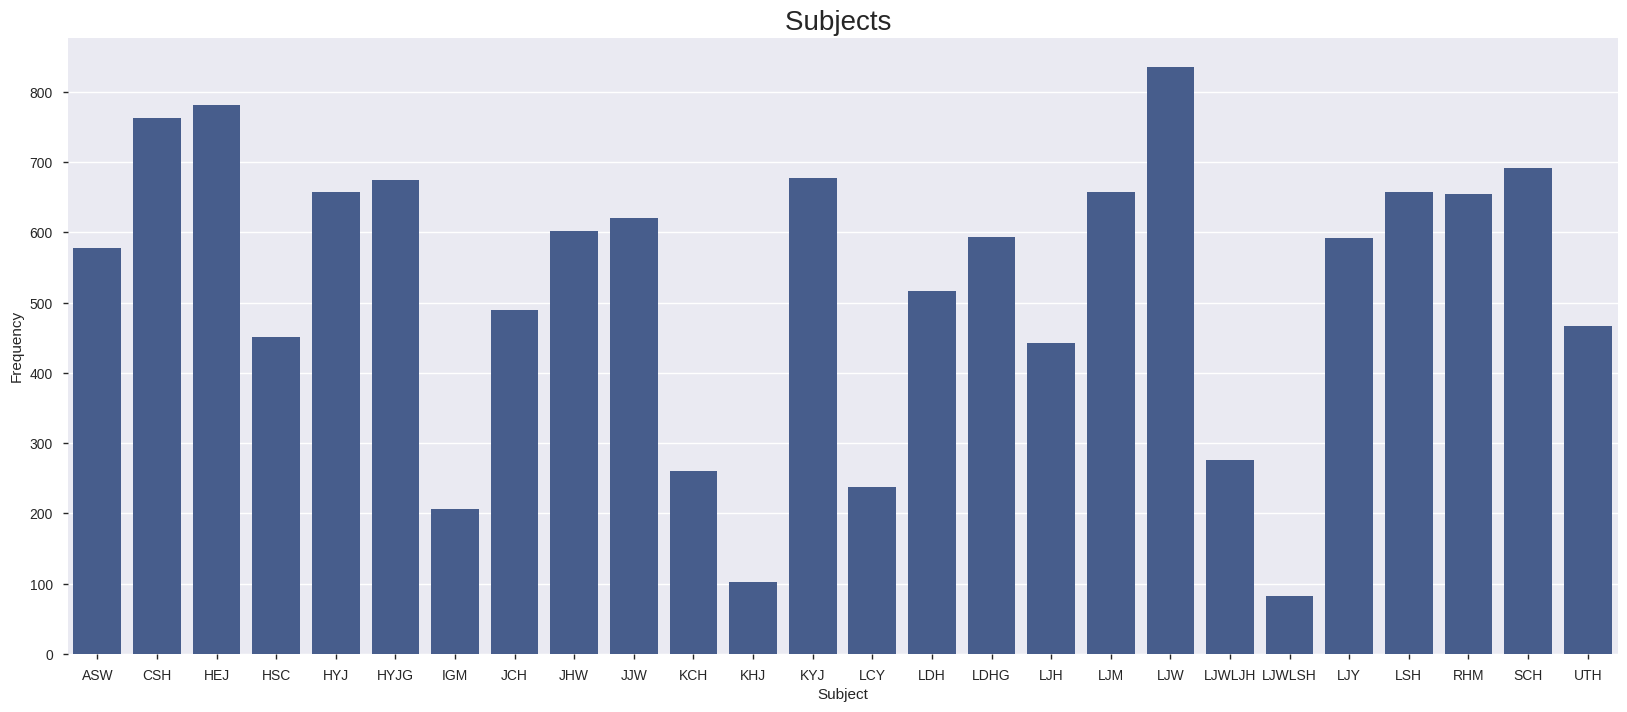

In [38]:
tmp = df.groupby(['subject']).size().reset_index(name='freq')

plt.figure(figsize=(20, 8))
sns.barplot(x='subject', y='freq', data=tmp, color=k_y)
plt.title('Subjects ', fontsize=20)
plt.xlabel('Subject')
_ = plt.ylabel('Frequency')

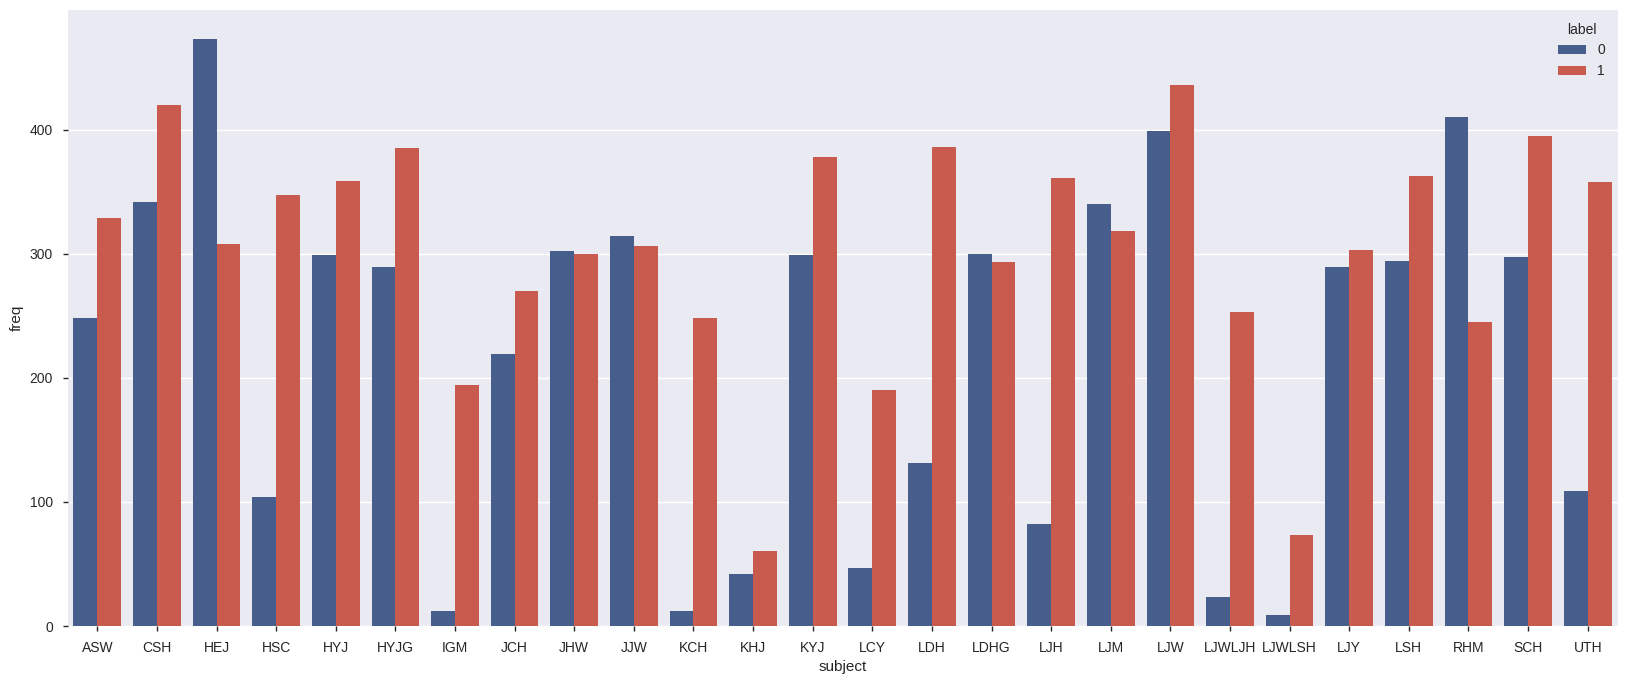

In [39]:
tmp = df.groupby(['label', 'subject']).size().reset_index(name='freq')

plt.figure(figsize=(20, 8))
_ = sns.barplot(x='subject', y='freq', hue='label', data=tmp, palette=my_colors)

## Number of data per label

0    5685
1    7878
Name: label, dtype: int64


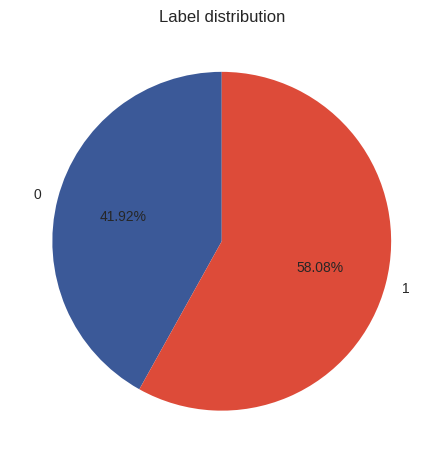

In [40]:
print(df['label'].value_counts().sort_index())

plt.pie(df['label'].value_counts().sort_index(), 
        labels=sorted(df['label'].unique()),
        colors=[k_y, k_b],
        startangle=90,
        autopct='%1.2f%%')
_ = plt.title('Label distribution')

* Label 0: 41.92%(5685장)
* Label 1: 58.08%(7878장)
* Label 1이 0보다 약 15% 더 많다.

#  Numerical Data EDA - Headpose

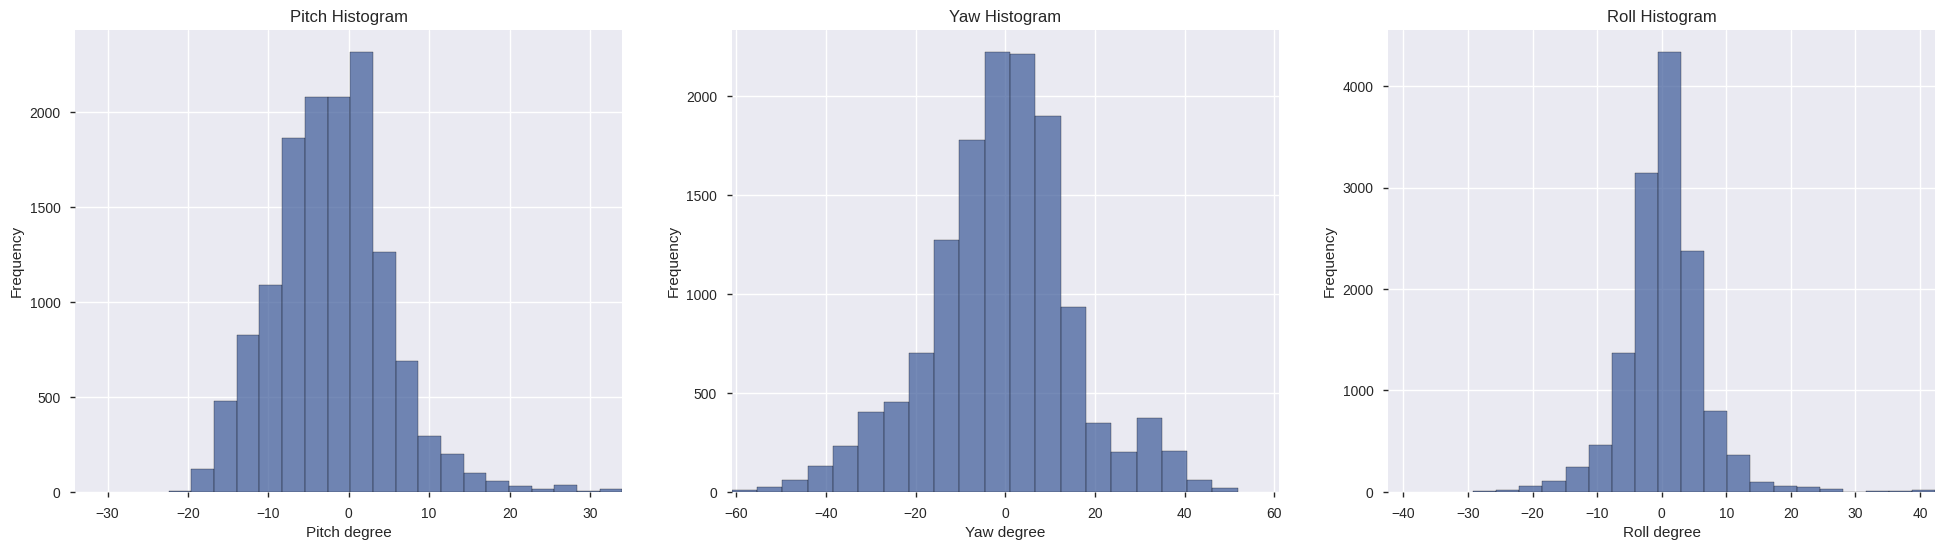

In [43]:
plt.figure(figsize=(24, 6))

plt.subplot(1, 3, 1)
x = df['head_pose_pitch']
plt.hist(x, bins=20, facecolor=k_y, alpha=0.7, edgecolor='black')  # or edgecolor='red'
plt.xlim(-max(abs(min(x)), abs(max(x))), +max(abs(min(x)), abs(max(x))))
plt.title('Pitch Histogram')
plt.xlabel('Pitch degree')
_ = plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
x = df['head_pose_yaw']
plt.hist(x, bins=20, facecolor=k_y, alpha=0.7, edgecolor='black')  # or edgecolor='red'
plt.xlim(-max(abs(min(x)), abs(max(x))), +max(abs(min(x)), abs(max(x))))
plt.title('Yaw Histogram')
plt.xlabel('Yaw degree')
_ = plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
x = df['head_pose_roll']
plt.hist(x, bins=20, facecolor=k_y, alpha=0.7, edgecolor='black')  # or edgecolor='red'
plt.xlim(-max(abs(min(x)), abs(max(x))), +max(abs(min(x)), abs(max(x))))
plt.title('Roll Histogram')
plt.xlabel('Roll degree')
_ = plt.ylabel('Frequency')

* Pitch, Yaw, Roll의 통계치와 히스토그램

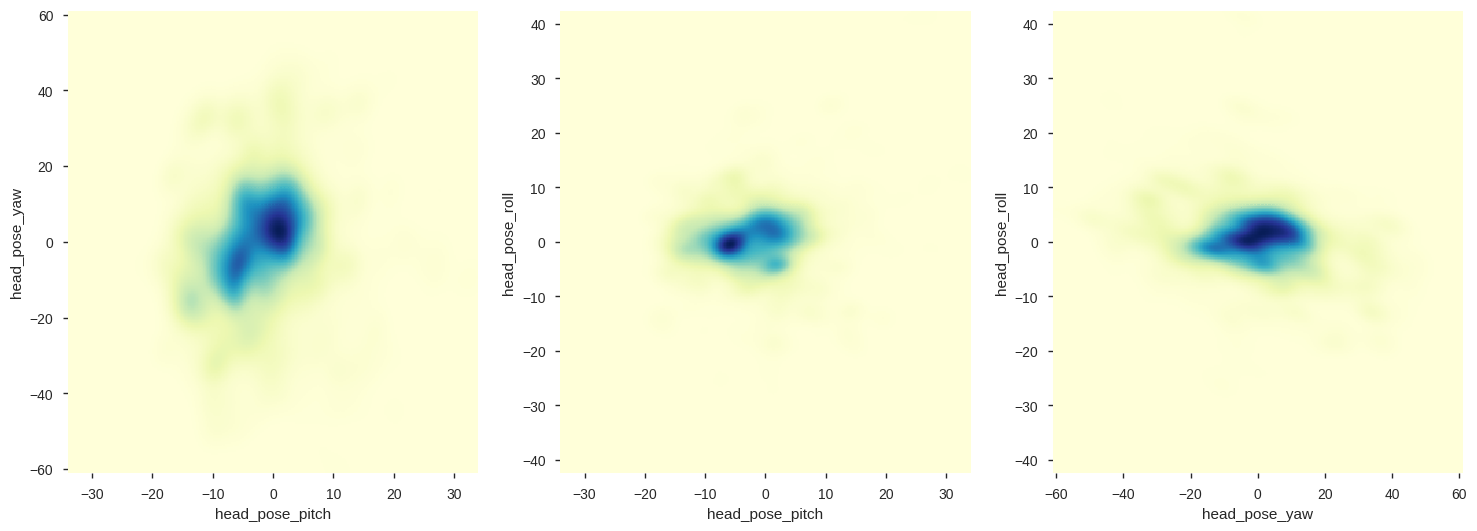

In [50]:
def plot_colormesh(x, y, nbins, cmap, data):
  x_name, y_name = x.split('_')[-1], y.split('_')[-1]

  x, y = data[x], data[y]
  k = kde.gaussian_kde([x, y])
  # xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
  xi, yi = np.mgrid[-max(abs(min(x)), abs(max(x))):max(abs(min(x)), abs(max(x))):nbins*1j,
                    -max(abs(min(y)), abs(max(y))):max(abs(min(y)), abs(max(y))):nbins*1j]
  zi = k(np.vstack([xi.flatten(), yi.flatten()]))
  
  plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=cmap)

plt.cm
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plot_colormesh(x='head_pose_pitch', y='head_pose_yaw', nbins=300, cmap=plt.cm.YlGnBu, data=df)
plt.xlabel('head_pose_pitch')
plt.ylabel('head_pose_yaw')

plt.subplot(1, 3, 2)
plot_colormesh(x='head_pose_pitch', y='head_pose_roll', nbins=300, cmap=plt.cm.YlGnBu, data=df)
plt.xlabel('head_pose_pitch')
plt.ylabel('head_pose_roll')

plt.subplot(1, 3, 3)
plot_colormesh(x='head_pose_yaw', y='head_pose_roll', nbins=300, cmap=plt.cm.YlGnBu, data=df)
plt.xlabel('head_pose_yaw')
plt.ylabel('head_pose_roll')

plt.show()

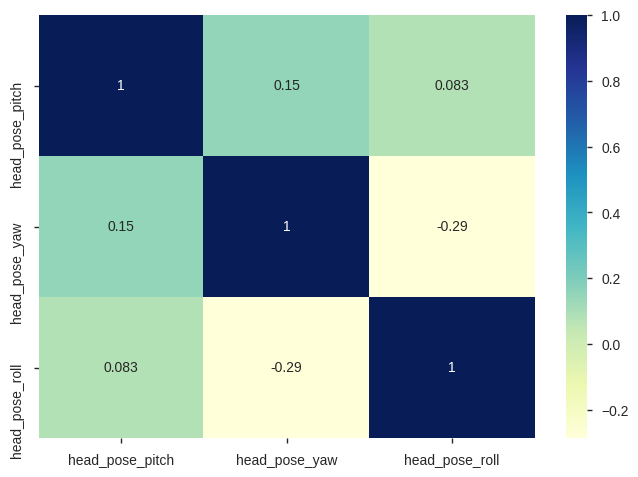

In [53]:
_ = sns.heatmap(df[['head_pose_pitch', 'head_pose_yaw', 'head_pose_roll']].corr(),
                annot=True,
                cmap='YlGnBu')

Head pose - pitch, yaw, roll 값의 관계

* 더 구체적으로 알아보기 위해 correlation matrix를 히트맵으로 표현함
* 위 2D density plot에서 살펴본대로 yaw와 roll의 상관계수는 -0.29로 약한 음의 상관관계를 가짐

        count  mean   std    min    25%   50%   75%    max
label                                                     
0      5685.0 -3.50  9.09 -22.39 -10.80 -4.23  1.37  34.02
1      7878.0 -1.26  4.93 -13.80  -5.29 -1.01  2.25  18.01 

        count  mean    std    min    25%   50%   75%    max
label                                                      
0      5685.0 -3.58  21.13 -61.02 -18.15 -4.46  8.99  51.87
1      7878.0  1.26  10.49 -39.91  -5.62  1.76  8.58  36.93 

        count  mean   std    min   25%   50%   75%    max
label                                                    
0      5685.0  0.99  7.61 -29.21 -2.91  1.03  4.56  42.35
1      7878.0  0.15  4.68 -27.98 -2.13  0.28  2.53  25.58


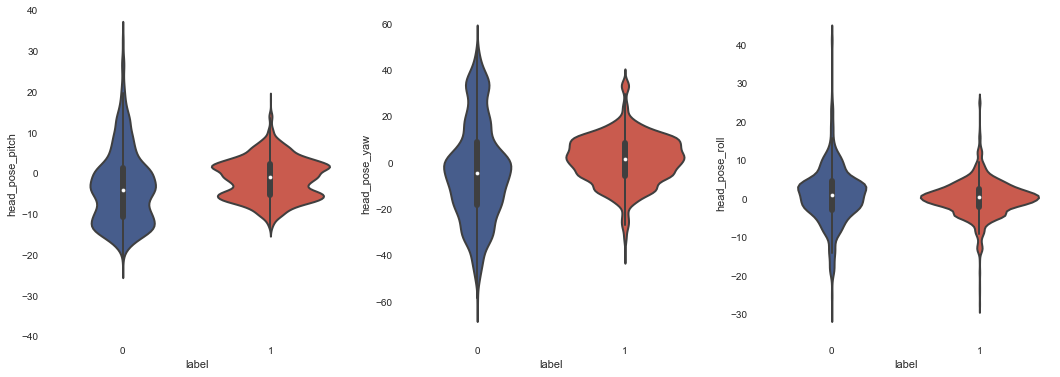

In [ ]:
print(np.round(meta_df.groupby('label')['head_pose_pitch'].describe(), 2), '\n')
print(np.round(meta_df.groupby('label')['head_pose_yaw'].describe(), 2), '\n')
print(np.round(meta_df.groupby('label')['head_pose_roll'].describe(), 2))

my_colors = {'0': k_y, '1': k_b}

# plot violinplot of pitch
tmp_df = meta_df.copy()
tmp_df['label'] = tmp_df['label'].astype('str')

f, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.violinplot(data=tmp_df, x="label", y="head_pose_pitch", linewidth=2, palette=my_colors, ax=axes[0])
axes[0].set(ylim=(-40, 40))
sns.violinplot(data=tmp_df, x="label", y="head_pose_yaw", linewidth=2, palette=my_colors, ax=axes[1])
_ = sns.violinplot(data=tmp_df, x="label", y="head_pose_roll", linewidth=2, palette=my_colors, ax=axes[2])

화면을 보지 않는 그룹(label 0)과 화면을 보는 그룹(label 1) 간의 Head pose 차이

* 두 그룹 간에 pitch, yaw, roll 값이 차이가 있는지 살펴보기 위해 violin plot을 그림
* pitch와 yaw는 두 그룹 사이에 차이가 있는 것으로 보임
* roll은 두 그룹 사이에 차이가 없는 것으로 보임

#  Statistical Hypothesis Testing

In [54]:
df_int = df.astype({'label': object, 'label': int})
df_int

,subject,frame_name,label,head_pose_pitch,head_pose_yaw,head_pose_roll
0,ASW,0_ASW_frame0,0,2.125730,19.042382,-5.182933
1,ASW,0_ASW_frame1,0,2.686390,18.510065,-8.522907
2,ASW,0_ASW_frame2,0,3.143057,21.237756,-10.432257
3,ASW,0_ASW_frame3,0,3.037692,21.580079,-13.670988
4,ASW,0_ASW_frame4,0,2.076509,21.283782,-12.232439
...,...,...,...,...,...,...
13558,UTH,1_UTH_frame353,1,2.781556,7.739024,2.900394
13559,UTH,1_UTH_frame354,1,2.806877,7.247055,2.345390
13560,UTH,1_UTH_frame355,1,3.112830,6.500977,2.256681
13561,UTH,1_UTH_frame356,1,2.108351,6.759132,1.863340


In [55]:
label_1 = df_int[df_int["label"] > 0]
label_0 = df_int[df_int["label"] == 0]

pl0 = label_0["head_pose_pitch"]
pl1 = label_1["head_pose_pitch"]
py0 = label_1["head_pose_yaw"]
py1 = label_0["head_pose_yaw"]
pr0 = label_1["head_pose_roll"]
pr1 = label_0["head_pose_roll"]

## Hypothesis Setting

귀무가설(H_0) : label0에서와 label1에서의 head_pose에서 'pitch', 'yaw', 'roll' 각각의 평균값의 차이가 있다고 할 수 없다

대립가설(H_1) : Not H_0

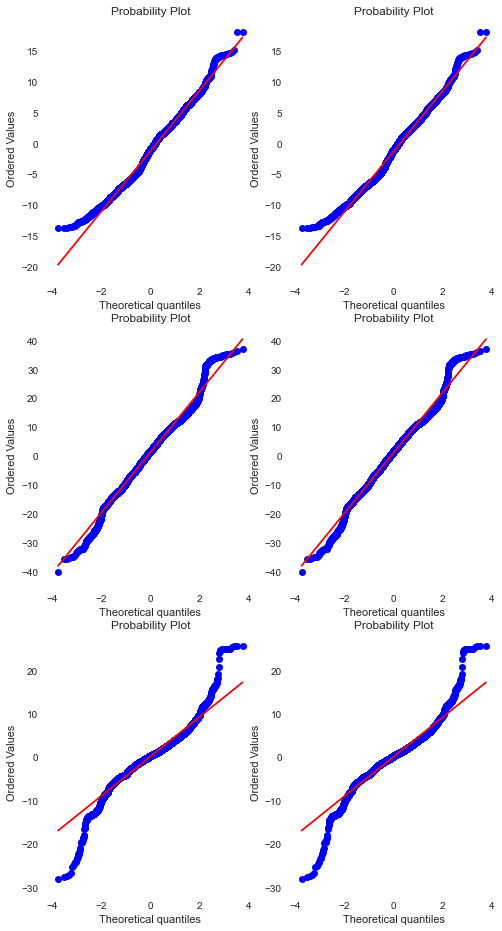

In [ ]:
plt.figure(figsize=(8, 16))
#plt.figure(figsize=(16,16))
plt.subplot(321)
stats.probplot(pl0, plot=plt)
plt.subplot(322)
stats.probplot(pl1, plot=plt)
plt.subplot(323)
stats.probplot(py0, plot=plt)
plt.subplot(324)
stats.probplot(py1, plot=plt)
plt.subplot(325)
stats.probplot(pr0, plot=plt)
plt.subplot(326)
stats.probplot(pr1, plot=plt)
plt.show()

위 qqplot은 데이터의 분위수(quantile)와 특정 이론적 분포의 quantile각각을 구하여 삱점도로 나타낸 그림이다. qqplot의 점들이 기울기의 직선상에 놓이면 자료가 해당 분포를 잘따른다고 할 수 있다. 위의 qqplot에서는 dataset의 점들이 선을 따라서 잘 붙어있다고 보기 어려움으로 정규성을 만족한다고 보기 어렵다.

In [ ]:
shapiro_pl = [shapiro(pl0), shapiro(pl1)]
print("Shapiro_test_pitch = " + str(shapiro_pl))
shapiro_py = [shapiro(py0), shapiro(py1)]
print("Shapiro_test_yaw = " + str(shapiro_py))
shapiro_pr = [shapiro(pr0), shapiro(pr1)]
print("Shapiro_test_roll = " + str(shapiro_pr))


Shapiro_test_pitch = [(0.9896267056465149, 1.403166298094882e-23), (0.9896267056465149, 1.403166298094882e-23)]
Shapiro_test_yaw = [(0.9892792105674744, 5.800174747423485e-24), (0.9892792105674744, 5.800174747423485e-24)]
Shapiro_test_roll = [(0.9449267387390137, 0.0), (0.9449267387390137, 0.0)]


C:\Anaconda\envs\Newproject\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


shapiro wilk test결과 qqplot그래프의 결과와 같이 p-value값이 매우 작아 정규성을 만족한다고 보기 어려운 것을 알 수 있다.

위의 qqplot과 shapiro wilk test결과를 통하여 두 집단(label0, label1)모두 정규성을 만족한다고 볼 수 없으므로 
모수적 방법인 t검정 대신 비모수적 방법인 윌콕슨 순위합 검정(wilcoxon rank sum test)
을 하는것이 적합하다고 볼 수 있다.  

In [ ]:
print("wilcoxon_rank_sum_test_pitch = " + str(ranksums(pl0, pl1)))
print("wilcoxon_rank_sum_test_yaw = " + str(ranksums(py0, py1)))
print("wilcoxon_rank_sum_test_roll = " + str(ranksums(pr0, pr1)))

wilcoxon_rank_sum_test_pitch = RanksumsResult(statistic=-23.547820165391098, pvalue=1.3216012902102662e-122)
wilcoxon_rank_sum_test_yaw = RanksumsResult(statistic=20.484559871080645, pvalue=2.956438173827247e-93)
wilcoxon_rank_sum_test_roll = RanksumsResult(statistic=-8.598026003000626, pvalue=8.10989264572072e-18)


윌콕슨 순위합 검정(wilcoxon ranksum test)를 수행해본 결과 위 처럼 p-value값이 유의수준 0.05에서 귀무가설(H_0)을 기각하는 것을 알 수 있다.